# Company Goal

# 1. Import all modules needed

In [41]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  ###to calculate roc & auc
from sklearn.metrics import log_loss

# 2. Evaluate the Deployed Model

In [3]:
# read 'DSA Data Set.csv' data file from the local
data = pd.read_csv('DSA Data Set.csv')

In [4]:
# check and display the first few rows of the data
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ModelPrediction,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.932750,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.953579,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.945724,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.933875,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.940996,no


In [18]:
# Create a column called "Year"

# create a list with a length 41188 with corresponding year
ls_2008 = [2008 for i in range(len(data.iloc[:27690]))]
ls_2009 = [2009 for i in range(len(data.iloc[27690:39130]))]
ls_2010 = [2010 for i in range(len(data.iloc[39130:]))]
year_list = ls_2008 + ls_2009 + ls_2010

data.insert(8, 'year', year_list)
data.head()

,age,job,marital,education,default,housing,loan,contact,year,month,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ModelPrediction,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,2008,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.932750,no
1,57,services,married,high.school,unknown,no,no,telephone,2008,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.953579,no
2,37,services,married,high.school,no,yes,no,telephone,2008,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.945724,no
3,40,admin.,married,basic.6y,no,no,no,telephone,2008,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.933875,no
4,56,services,married,high.school,no,no,yes,telephone,2008,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0.940996,no


In [58]:
# Convert 'ModelPrediction' to Boolean (0,1) based on threshold 0.5 
eval_deployed_model = data[['ModelPrediction','y']]
eval_deployed_model['raw_ModelPrediction'] = eval_deployed_model['ModelPrediction']
eval_deployed_model['y_pred'] = eval_deployed_model['ModelPrediction'].apply(lambda x:1 if x>=0.5 else 0)
eval_deployed_model['y_true'] = eval_deployed_model['y'].apply(lambda x: 1 if x=='yes' else 0)
eval_deployed_model['year'] = data['year']

In [59]:
eval_deployed_model.head()

,ModelPrediction,y,raw_ModelPrediction,y_pred,y_true,year
0,0.932750,no,0.932750,1,0,2008
1,0.953579,no,0.953579,1,0,2008
2,0.945724,no,0.945724,1,0,2008
3,0.933875,no,0.933875,1,0,2008
4,0.940996,no,0.940996,1,0,2008


In [51]:
# Evaluation Metric No.1 -- Confusion Matrix
cm_array = metrics.confusion_matrix(eval_deployed_model['y_true'], eval_deployed_model['y_pred'])
cm_array

array([[  257, 36291],
       [  680,  3960]])

<AxesSubplot:>

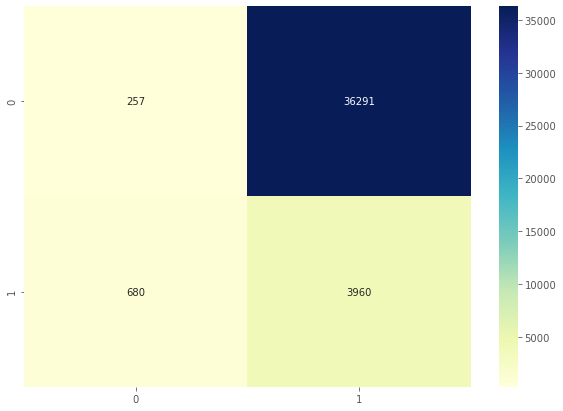

In [116]:
# plot confusion matrix
df_cm = pd.DataFrame(cm_array, index = [0,1],
                  columns = [0,1])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [64]:
# Evaluation Metric No. 2 -- Recall, Precision, Accuracy, F1, F1_beta Score
def evaluation_metrics(data_in_year, y_pred, y_true, beta_val):
    y_pred = data_in_year[y_pred]
    y_true = data_in_year[y_true]
    cr = metrics.classification_report(y_true, y_pred)
    accuracy_score_in_year = round(accuracy_score(y_true, y_pred),4)*100
    recall_score_in_year = round(recall_score(y_true, y_pred),4)*100
    precision_score_in_year = round(precision_score(y_true, y_pred),4)*100
    f1_score_in_year = round(f1_score(y_true, y_pred),4)*100
    F_beta = round(fbeta_score(y_true, y_pred, beta=beta_val),4)*100
    print('Accuracy Score is: ', accuracy_score_in_year, ' %')
    print('Recall Score is: ', recall_score_in_year, ' %')
    print('Precision Score is: ', precision_score_in_year, ' %')
    print('F1 Score is: ', f1_score_in_year, ' %')
    print('F1 Score with Beta =', beta_val,  'is:', F_beta, ' %')
    print('Classification Report is: ')
    print(cr)

In [65]:
evaluation_metrics(eval_deployed_model,'y_pred','y_true', 2)

Accuracy Score is:  10.24  %
Recall Score is:  85.34  %
Precision Score is:  9.84  %
F1 Score is:  17.64  %
F1 Score with Beta = 2 is: 33.67  %
Classification Report is: 
              precision    recall  f1-score   support

           0       0.27      0.01      0.01     36548
           1       0.10      0.85      0.18      4640

    accuracy                           0.10     41188
   macro avg       0.19      0.43      0.10     41188
weighted avg       0.25      0.10      0.03     41188



In [73]:
# Evaluation Metric No. 3 -- AUC & ROC

# define auc_roc function
def auc_roc(y_test, y_score):
    # Compute ROC curve and ROC area for each class
    fpr,tpr,threshold = roc_curve(y_test, y_score) # Calculate True Postiive and False Positive Rate
    roc_auc = auc(fpr,tpr) # calcualte auc value

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ### x-axis represents FP, y-axis represents TP
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    #plt.savefig(pltname)
    #plt.close
    plt.show()


<Figure size 432x288 with 0 Axes>

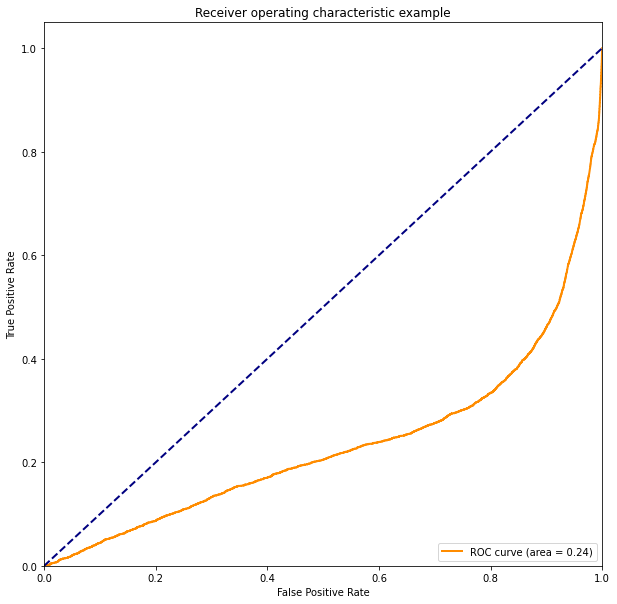

In [77]:
auc_roc(eval_deployed_model['y_true'], eval_deployed_model['raw_ModelPrediction'])

# Evaluation Performance in each Year

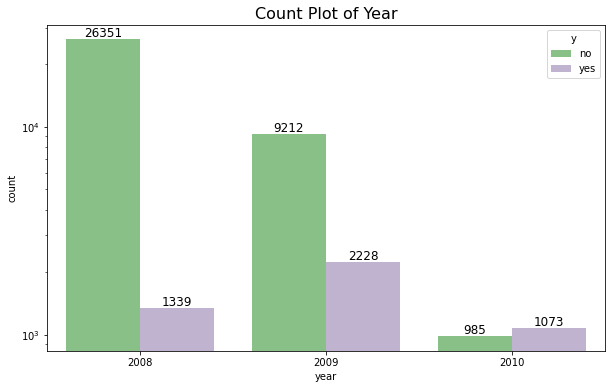

In [71]:
# Count Plot of Year
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6)) #nrows, nclos = number of rows/columns of the subplot grid
sns.countplot(x='year', hue='y',palette='Accent', data=data, ax=ax)
ax.set_title('Count Plot of Year', fontsize=16)
ax.set_yscale('log')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()

In [70]:
# Evaluate the model in each Year 2008, 2009, 2010
eval_deployed_model_2008 = eval_deployed_model[eval_deployed_model['year']==2008]
eval_deployed_model_2009 = eval_deployed_model[eval_deployed_model['year']==2009]
eval_deployed_model_2010 = eval_deployed_model[eval_deployed_model['year']==2010]


# in Year 2008
print('In Year 2008: ')
print()
evaluation_metrics(eval_deployed_model_2008,'y_pred','y_true', 2)
print()

# in Year 2009
print('In Year 2009: ')
print()
evaluation_metrics(eval_deployed_model_2009,'y_pred','y_true', 2)
print()

# in Year 2008
print('In Year 2010: ')
print()
evaluation_metrics(eval_deployed_model_2010,'y_pred','y_true', 2)

In Year 2008: 

Accuracy Score is:  4.84  %
Recall Score is:  100.0  %
Precision Score is:  4.84  %
F1 Score is:  9.229999999999999  %
F1 Score with Beta = 2 is: 20.26  %
Classification Report is: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     26351
           1       0.05      1.00      0.09      1339

    accuracy                           0.05     27690
   macro avg       0.02      0.50      0.05     27690
weighted avg       0.00      0.05      0.00     27690


In Year 2009: 

Accuracy Score is:  18.72  %
Recall Score is:  91.38  %
Precision Score is:  18.27  %
F1 Score is:  30.45  %
F1 Score with Beta = 2 is: 50.760000000000005  %
Classification Report is: 
              precision    recall  f1-score   support

           0       0.35      0.01      0.02      9212
           1       0.18      0.91      0.30      2228

    accuracy                           0.19     11440
   macro avg       0.27      0.46      0.16     11440
w

# 3. Data Analysis

In [78]:
# check the statistic summary of numeric columns
data.describe()

,age,year,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ModelPrediction
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2008.377683,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.887597
std,10.42125,0.578773,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.125351
min,17.00000,2008.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.250174
25%,32.00000,2008.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.857484
50%,38.00000,2008.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.945879
75%,47.00000,2009.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.959214
max,98.00000,2010.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,0.988360


In [79]:
# total of 10 numeric columns shown as below

# please be careful about the column 'pdays' because 999 means client was not previously contacted.

In [83]:
# verify the unique values in each categorical column
def check_unique(df_name, col_name):
    print('-- ',col_name, ': ', df_name[col_name].unique())
check_unique(data, 'job')
check_unique(data, 'marital')
check_unique(data, 'education')
check_unique(data, 'default')
check_unique(data, 'housing')
check_unique(data, 'loan')
check_unique(data, 'month')
check_unique(data, 'day_of_week')
check_unique(data, 'poutcome')
check_unique(data, 'job')

--  job :  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
--  marital :  ['married' 'single' 'divorced' 'unknown']
--  education :  ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
--  default :  ['no' 'unknown' 'yes']
--  housing :  ['no' 'yes' 'unknown']
--  loan :  ['no' 'yes' 'unknown']
--  month :  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
--  day_of_week :  ['mon' 'tue' 'wed' 'thu' 'fri']
--  poutcome :  ['nonexistent' 'failure' 'success']
--  job :  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


In [86]:
# Identify missing values
data.isnull().sum()

age                0
job                0
marital            0
education          0
default            0
housing            0
loan               0
contact            0
year               0
month              0
day_of_week        0
duration           0
campaign           0
pdays              0
previous           0
poutcome           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
euribor3m          0
nr.employed        0
ModelPrediction    0
y                  0
dtype: int64

In [84]:
# However, if  the value 'unkonwn' counts as missing, the following shows % of 'unknown' values in each column
def missing_value_percentage(col_name):
    missing_value_pct = round(len(data[(data[col_name]=='unknown') | (data[col_name]==999)])/len(data),2)*100
    return str(missing_value_pct) + "% values are missing in the column " + "'" + col_name + "'"

In [85]:
print(missing_value_percentage('pdays'))
print(missing_value_percentage('job'))
print(missing_value_percentage('marital'))
print(missing_value_percentage('education'))
print(missing_value_percentage('default'))
print(missing_value_percentage('housing'))
print(missing_value_percentage('loan'))
print(missing_value_percentage('previous'))

96.0% values are missing in the column 'pdays'
1.0% values are missing in the column 'job'
0.0% values are missing in the column 'marital'
4.0% values are missing in the column 'education'
21.0% values are missing in the column 'default'
2.0% values are missing in the column 'housing'
2.0% values are missing in the column 'loan'
0.0% values are missing in the column 'previous'


<AxesSubplot:xlabel='age', ylabel='Density'>

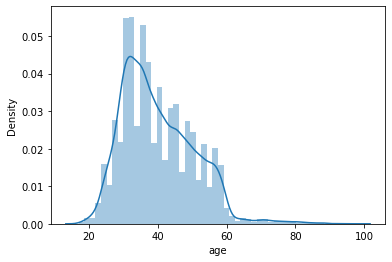

In [87]:
# Check Outliers
sns.distplot(data.age)

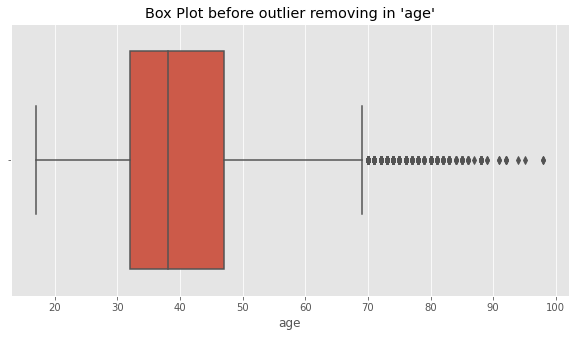

In [96]:
sns.boxplot(data['age'])
plt.title("Box Plot before outlier removing in 'age'")
plt.show()

In [97]:
outlier_count_in_age = data['age'][data['age']>70].count()
print("Total of", outlier_count_in_age, "outliers in 'age' column")

Total of 422 outliers in 'age' column


# 4. Clean Data

In [ ]:
# Handle Outliers

In [ ]:
# Handle Missing Values

Conclusion:
    
I decide to drop 'pdays' columns beacuse the % missing values are close to 100%

In [98]:
# Check & Remove Duplicate
data.duplicated().any()

True

In [99]:
data[data.duplicated()==1]

,age,job,marital,education,default,housing,loan,contact,year,month,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,ModelPrediction,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,2008,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0.945200,no
12261,36,retired,married,unknown,no,no,no,telephone,2008,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0.956465,no
14234,27,technician,single,professional.course,no,no,no,cellular,2008,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0.956728,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,2008,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0.961048,no
18465,32,technician,single,professional.course,no,yes,no,cellular,2008,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0.955202,no
20216,55,services,married,high.school,unknown,no,no,cellular,2008,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0.970002,no
20534,41,technician,married,professional.course,no,yes,no,cellular,2008,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0.956788,no
25217,39,admin.,married,university.degree,no,no,no,cellular,2008,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0.932301,no
28477,24,services,single,high.school,no,yes,no,cellular,2009,apr,...,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,0.842341,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,2009,may,...,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0.827244,no


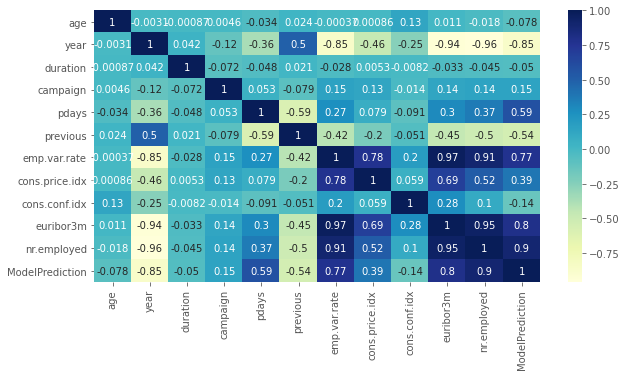

In [100]:
# Check and remove highly correlated Inputs
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [101]:
# look into the subset columns -- check correlations between the following suspecious columns
data[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].corr()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
emp.var.rate,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,0.906970,0.522034,0.100513,0.945154,1.000000


In [102]:
# To get the non redundant number of columns in each group
#, we divide the total number of columns in the group by this number.
(data[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].corr()**2).sum().sum()/5

# the result 2.655 means that the group actually has 2.655 columns 'worth' of information
# For the sake of conservation, I decide to keep only 2 columns

2.655047491687669

In [103]:
# calculate a redundancy score for each column
# , which is the sum of the squares of correlation between that column and all other columns in the data 
C_2 = (data[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].corr()**2).sum(axis=1)
C_2.sort_values(ascending=False)

emp.var.rate      3.407430
euribor3m         3.389347
nr.employed       2.998534
cons.price.idx    2.350803
cons.conf.idx     1.129124
dtype: float64

Conclusion

I decide to discard 'emp.var.rate', 'euribor3m', 'nr.employed'  3 columns

In [104]:
# As a result, I decide to take the following actions for data cleaning purpose

In [105]:
df = pd.read_csv('DSA Data Set.csv')
df.dropna(inplace=True)

# drop irrelevant columns
df = df.drop(['duration'],axis=1)
df = df.drop(['ModelPrediction'],axis=1)

# drop time-related columns 
# since I believe they will have little impact on the outcome, so drop them for a clean data
df = df.drop(['month'],axis=1)
df = df.drop(['day_of_week'],axis=1)

# drop 'pdays' beacuse the % missing values are close to 100%
df = df.drop(['pdays'],axis=1)

# drop columns with high redundacy scores
df = df.drop(['emp.var.rate', 'euribor3m', 'nr.employed'],axis=1)

In [107]:
df.head()

,age,job,marital,education,default,housing,loan,contact,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,1,0,nonexistent,93.994,-36.4,no
1,57,services,married,high.school,unknown,no,no,telephone,1,0,nonexistent,93.994,-36.4,no
2,37,services,married,high.school,no,yes,no,telephone,1,0,nonexistent,93.994,-36.4,no
3,40,admin.,married,basic.6y,no,no,no,telephone,1,0,nonexistent,93.994,-36.4,no
4,56,services,married,high.school,no,no,yes,telephone,1,0,nonexistent,93.994,-36.4,no


In [108]:
# Implement Label Encoding


In [109]:
#ordinal encoding function

#education
edu_map = {'unknown':0,'illiterate':1,'basic.4y':2,'basic.6y':3,'basic.9y':4,'high.school':5, 'university.degree':6, 'professional.course':7 }
df['education'] = df['education'].apply(lambda x: edu_map[x])
df['edu_know'] = df['education'].apply(lambda x: 1 if x else 0)

#poutcome
#print(df.poutcome.unique())
poutcome_map = {'nonexistent':0, 'failure':1, 'success':2}
df['poutcome'] = df['poutcome'].apply(lambda x:poutcome_map[x])

#y
df['y'] = df['y'].apply(lambda x:0 if x=='no' else 1)

#One-hot Encoding
encoder = OneHotEncoder(cols=['job', 'marital','default','housing','loan','contact'], 
                        handle_unknown='indicator', 
                        handle_missing='indicator', 
                        use_cat_names=True).fit(df)
encoded_df = encoder.transform(df)

In [114]:
encoded_df

,age,job_housemaid,job_services,job_admin.,job_blue-collar,job_technician,job_retired,job_management,job_unemployed,job_self-employed,...,contact_cellular,contact_nan,contact_-1,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,y,edu_know
0,56,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,93.994,-36.4,0,1
1,57,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,93.994,-36.4,0,1
2,37,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,93.994,-36.4,0,1
3,40,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,93.994,-36.4,0,1
4,56,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,93.994,-36.4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,94.767,-50.8,1,1
41184,46,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,94.767,-50.8,0,1
41185,56,0,0,0,0,0,1,0,0,0,...,1,0,0,2,0,0,94.767,-50.8,0,1
41186,44,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,94.767,-50.8,1,1


# 5. Split to Train Data and Test Data 

In [111]:
df_train,df_test=train_test_split(encoded_df,train_size=0.7,test_size=0.3,random_state=100)

In [112]:
df_train.shape

(28831, 48)

In [113]:
df_test.shape

(12357, 48)